In [205]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

# if you have not install scikit-learn, run "conda install scikit-learn" in your gct634 environment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import mixture



# PCA

### Loading Input Data

(4996, 513)


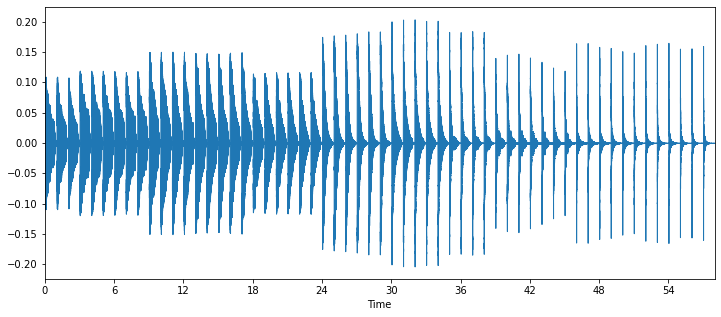

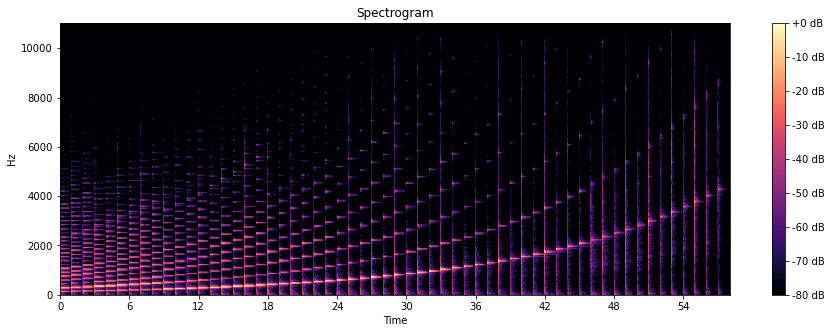

In [108]:

# input audio
filename = "../audio/piano_88keys_short_vel96_part2.wav"

y, sr = librosa.load(filename) 

plt.figure(figsize=(12, 5))
librosa.display.waveplot(y, sr=sr)

# STFT
S_full, phase = librosa.magphase(librosa.stft(y, n_fft=1024, window='hann', hop_length=256, win_length=1024))
n = len(y)

fig, ax = plt.subplots(sharex=True, figsize=(15,5))
img = librosa.display.specshow(librosa.amplitude_to_db(S_full,ref=np.max), hop_length=256, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.set(title='Spectrogram')

# Check the shape of matrix: row must corresponds to the example index !!!
X = S_full.T
print (X.shape)


ipd.Audio(y, rate=sr) 


### Observing the variances 

[0.12748884 0.11031926 0.08516804 0.065491   0.05909206]


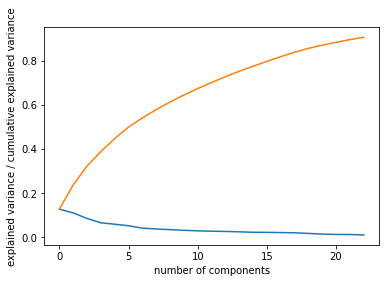

In [109]:
#pca = PCA()
#pca = PCA(n_components=50)
pca = PCA(0.9) # accumulated variances

# training
pca.fit(X)

print(pca.explained_variance_ratio_[:5])
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance / cumulative explained variance');


### Visualization Using PCA

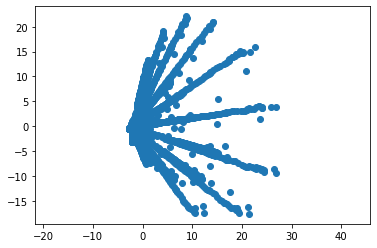

In [110]:
pca = PCA(n_components=2)

# training
pca.fit(X)
X_pca = pca.transform(X)

# display 
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.axis('equal');


### Data Compression Using PCA

(4996, 513)
(4996, 23)
(4996, 513)


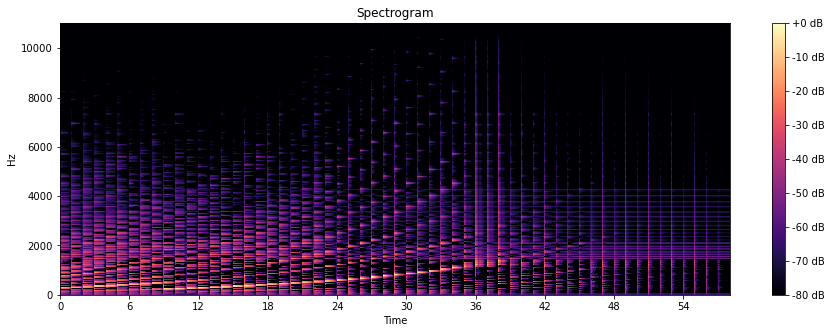

In [130]:
pca = PCA(0.9)
#print(pca.n_components)

# training
pca.fit(X)

# PCA transform 
X_pca = pca.transform(X)
print(X.shape)
print(X_pca.shape)

# reconstruction
X_recon = pca.inverse_transform(X_pca)
print(X_recon.shape)

# set negatives to zero 
X_recon[X_recon<0] = 0

X_recon = X_recon.T

# inverse STFT
y_hat = librosa.istft(X_recon*np.exp(phase), window='hann', hop_length=256, win_length=1024, length=n)

fig, ax = plt.subplots(sharex=True, figsize=(15,5))
img = librosa.display.specshow(librosa.amplitude_to_db(X_recon,ref=np.max), hop_length=256, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.set(title='Spectrogram')

ipd.Audio(y_hat, rate=sr)

# K-Means Clustering

### loading audio

(359, 513)


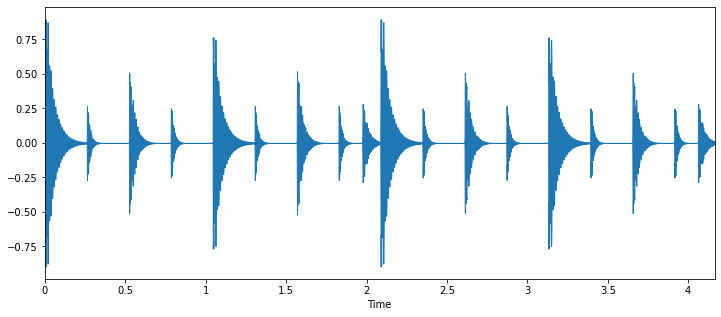

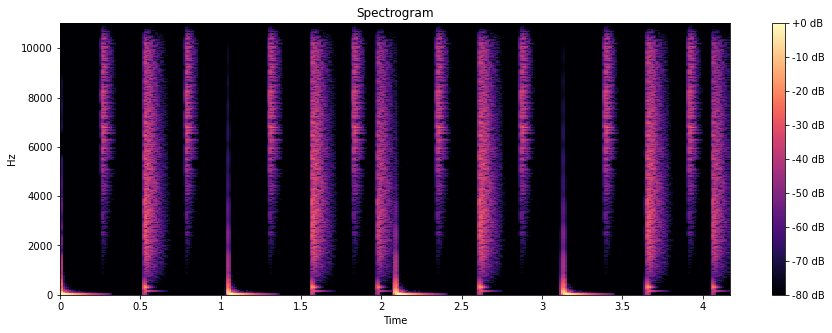

In [131]:

# input audio
filename = "../audio/beatbox.wav"

y, sr = librosa.load(filename) 


plt.figure(figsize=(12, 5))
librosa.display.waveplot(y, sr=sr)


# STFT
S_full, phase = librosa.magphase(librosa.stft(y, n_fft=1024, window='hann', hop_length=256, win_length=1024))
n = len(y)

fig, ax = plt.subplots(sharex=True, figsize=(15,5))
img = librosa.display.specshow(librosa.amplitude_to_db(S_full,ref=np.max), hop_length=256, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.set(title='Spectrogram')

# Check the shape of matrix: row must corresponds to the example index !!!
X = S_full.T
print (X.shape)


ipd.Audio(y, rate=sr) 


### Vector Quantization Using K-means

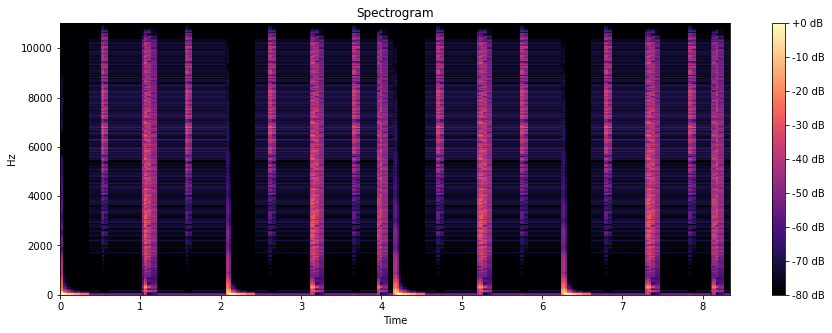

In [140]:

# K-Means Clustering

K = 20
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

X_rec = np.zeros(X.shape)

for i in range(X.shape[0]):
    X_rec[i,:] = kmeans.cluster_centers_[kmeans.labels_[i]]

# back to the spectrogram shape
X_hat = X_rec.T

# inverse STFT
y_hat = librosa.istft(X_hat*np.exp(phase), window='hann', hop_length=256, win_length=1024, length=n)


fig, ax = plt.subplots(sharex=True, figsize=(15,5))
img = librosa.display.specshow(librosa.amplitude_to_db(X_hat,ref=np.max), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.set(title='Spectrogram')

ipd.Audio(y_hat, rate=sr) 


# GMM

###  Feature Visualization

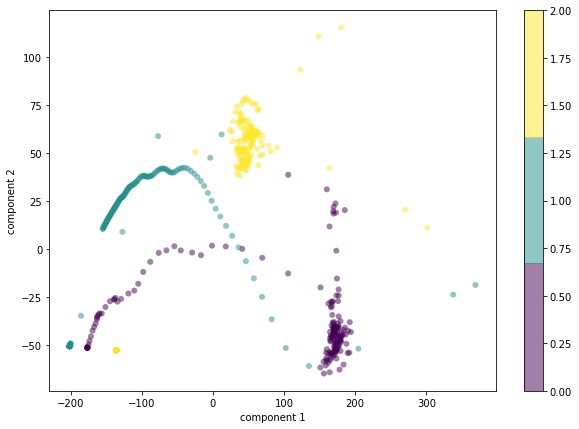

In [256]:

# input audio
filename1 = "../audio/brass_acoustic_000-060-100.wav"
filename2 = "../audio/guitar_acoustic_018-060-100.wav"
filename3 = "../audio/organ_electronic_003-060-100.wav"
filename4 = "../audio/organ_electronic_003-062-100.wav"

y1, sr = librosa.load(filename1) 
y2, sr = librosa.load(filename2) 
y3, sr = librosa.load(filename3) 
y4, sr = librosa.load(filename4) 

X1 = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=13).T
X2 = librosa.feature.mfcc(y=y2, sr=sr, n_mfcc=13).T
X3 = librosa.feature.mfcc(y=y3, sr=sr, n_mfcc=13).T
X_test = librosa.feature.mfcc(y=y4, sr=sr, n_mfcc=13).T
X_train = np.concatenate([X1, X2, X3])

Y1 = np.zeros(X1.shape[0], dtype=int)
Y2 = np.ones(X2.shape[0], dtype=int)
Y3 = np.ones(X3.shape[0], dtype=int)*2
Y_train = np.concatenate([Y1, Y2, Y3])

# PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

fig, ax = plt.subplots(sharex=True, figsize=(10,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=Y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();



### Likelihood estimation

In [257]:

gmm1 = mixture.GaussianMixture(n_components=1, covariance_type='diag')
gmm2 = mixture.GaussianMixture(n_components=1, covariance_type='diag')
gmm3 = mixture.GaussianMixture(n_components=1, covariance_type='diag')

gmm1.fit(X1)
gmm2.fit(X2)
gmm3.fit(X3)

print(gmm1.score(X_test))
print(gmm2.score(X_test))
print(gmm3.score(X_test))


-71.56317565947124
-63.96298738836543
-54.64361965404813
